# 5. Reconstrucción de Imágenes con SVD

En este notebook se estudian algunos aspectos de la reconstrucción de una imagen utilizando Descomposición en Valores Singulares.

In [1]:
from matplotlib.image import imread
from matplotlib.image import imsave
import matplotlib.pyplot as plt
import numpy as np
import os

## 1. Carga de una imagen en una matriz

Se utilizará una imagen convertida a escala de grises que se cargará en la matriz $A$.

In [2]:
TEST_IMAGE_FILENAME = 'data/koala.jpeg'

In [3]:
def load_img_into_matrix(filename):
    img_orig = imread(filename) # En img_orig se guarda un arreglo de tres matrices cada una de ellas contiene la intensidad del piexel en los canales RGB.
    A=np.mean(img_orig,-1)  # Acá se promedia la intensidad de todos los canales.
    return A

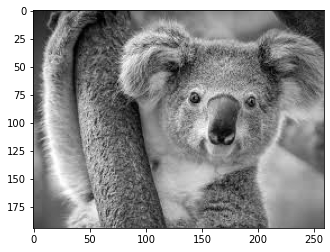

In [4]:
A = load_img_into_matrix(TEST_IMAGE_FILENAME)
plt.imshow(A)
plt.set_cmap('gray')   
plt.show()

## 2. Descomposición por valores singulares y reconstrucción de la matriz

Dada una matriz $A$, la función *svd_reconstruct()* generará una nueva matriz $A_{red}$ reconstruida a partir de la descomposición de $A$ usando los $k_0$ a $k_1$ valores singulares. También se devuelven los valores encontrados en un array $\sigma$.

In [5]:
def svd_reconstruct(A,k0, k1):
    U, s, VT=np.linalg.svd(A) # Se calcula la SVD de la matriz con la que estamos trabajando.
    S=np.diag(s) # La SVD devuelve los valores singulares y acá construimos la matriz Sigma.   
    Ared = U[:,k0:k1] @ S[k0:k1,k0:k1] @ VT[k0:k1,:]; # Recompone la imágen usando los k valores singulares seleccionados.
    return Ared, s

In [6]:
def plot_reconstructed(A,k):
    fig, ax = plt.subplots(1,2,figsize=(16,8))
    fig.suptitle("Reconstrucción de imagen")
    Ared,s = svd_reconstruct(A,k0=0,k1=k)
    img = ax[0].imshow(A)
    img.set_cmap('gray')   
    ax[0].set_title("Original")
    ax[0].axis('off')
    img = ax[1].imshow(Ared)
    img.set_cmap('gray')   
    ax[1].set_title(f"Reconstruída con $k_0=0, k_1={k}$")
    ax[1].axis('off')
    plt.show()
    return Ared, s

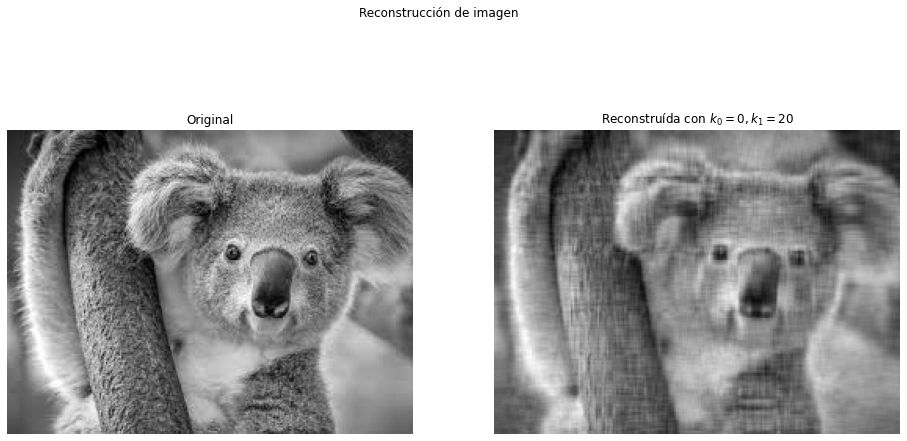

(194,)

In [7]:
Ared, s = plot_reconstructed(A,20)
s.shape

A continuación se muestran los valores de $\sigma$. El primer gráfico muestra los valores de $\sigma$ en escala logarítimca en el eje $y$ y el segundo gráfico muestra la energía acumulada.Luego se verá el efecto de reconstruir la matriz utilizando distintos intervalos de valor inicial y final de $\sigma$ y estos gráficos serán de interés para entender un método para encontrar el valor óptimo de truncado que encuentre un buen balance entre compresión y preservación del detalle.

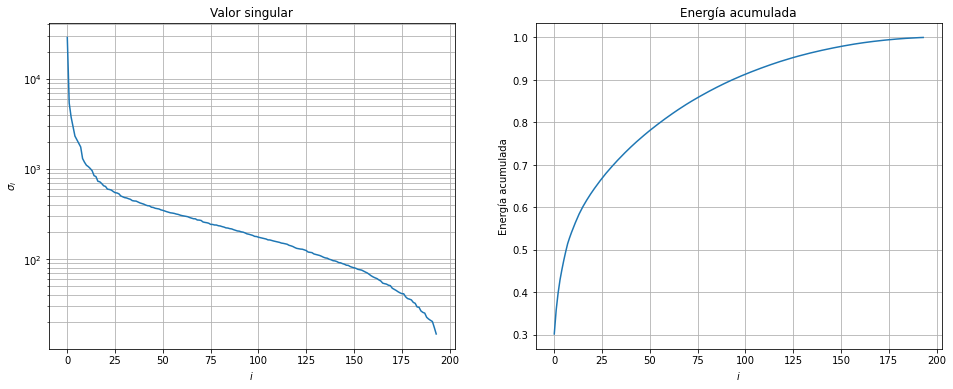

In [8]:
def plot_sigma(s):
    s_index = np.arange(s.shape[0])
    fig, ax = plt.subplots(1,2,figsize=(16,6))
    
    ax[0].set_title("Valor singular")
    ax[0].plot(s_index, s)
    ax[0].grid(which="Both")
    ax[0].set_ylabel("$\sigma_i$")
    ax[0].set_yscale("log")
    ax[0].set_xlabel("$i$")
    
    ax[1].set_title("Energía acumulada")
    ax[1].plot(s_index, np.cumsum(s)/np.sum(s))
    ax[1].grid(which="Both")
    ax[1].set_ylabel("Energía acumulada")
    ax[1].set_xlabel("$i$")
    
plot_sigma(s)

### 2.1 Métricas

Interesa obtener algunas métricas de la imagen reconstruída.

#### 2.1.1 Factor de compresión

La siguiente función permite tener una idea del factor de compresión comparando los tamaños de los archivos generados. Se debe tener en cuenta que los archivos ya son afectados por la compresión JPEG, por lo que no es una métrica precisa del factor real de compresión que se obtiene con SVD.

In [9]:
def reduction_factor_file_sz(Ared,orig_filename):
    # Guardar la imagen (temporal)
    tmp_filename = "tmp.jpg"
    imsave(tmp_filename,Ared,cmap="gray");
    # Esto es para comparar los tamaños de los archvos y ver cuánto se redujo.
    sizeOrig=os.stat(orig_filename).st_size;
    sizeRed=os.stat(tmp_filename).st_size;
    reduc=100*(sizeOrig-sizeRed)/sizeOrig; # Porcentaje de reducción.
    #print(f"Compresión: sz_orig:{sizeOrig}, sz_red:{sizeRed}, reduc:{reduc}")
    return reduc

In [10]:
print("Porcentaje de reducción: %.02f%%" % reduction_factor_file_sz(Ared,orig_filename=TEST_IMAGE_FILENAME))

Porcentaje de reducción: 14.08%


Como no es el objetivo incluir en la métrica la compresión del algoritmo que utiliza JPEG, quizás sea de mayor interés esta otra métrica que representa el factor de compresión respecto a las dimensiones de la matriz original considerando que para poder reconstruir la imagen aproximada sólo se necesitan dos matrices de dimensiones $U_{nk}$, $V_{mk}$ y un vector $\sigma$ de $k$ elementos:

$$
R = \frac{nk + k + mk}{nm}
$$

In [11]:
def reduction_factor(m,n, k):
    return 100.0 - (k*(1+m+n))/(n*m) * 100.0   

In [12]:
print("Factor de compresión: %.02f%%" % reduction_factor(A.shape[0], A.shape[1],20) )

Factor de compresión: 81.93%


#### 2.1.2 Error de la aproximación o distancia entre la matriz reconstruída y la original

Una forma sencilla de tener una estimación del error de la matriz reconstruida respecto de la original es con el error cuadrático medio.

In [13]:
mse = ((A-Ared)**2).mean()
print("MSE: %.2f " % mse )

MSE: 217.20 


### 2.2 Análisis variando $k_0$ y $k_1$

Se estudiará la matriz aproximada para distintos valores iniciales y finales de $\sigma$ manteniendo primero el valor inicial fijo en 0 e incrementando gradualmente el rango de $\Sigma$ y luego manteniendo el rango e incrementando el valor inicial. Para ello se define la siguiente función:

In [14]:
def perform_svd_analysis(filename, nk, initial_k, end_k, fixed_k_idx, fixed_k_value, nx = 4):    
    """ A partir de una imagen realiza reconstrucciones por SVD usando distintos valores de k, 
        manteniendo uno de ellos fijo. y las muestra en un gráfico.
    nk: Cantidad de valores de K a generar    
    k0: Valor inicial de k
    k1: Valor final de k    
    fixed_k_idx: Índice del k que se mantiene fijo
    fixed_k_value: Valor del k que se mantiene fijo
    nx: Cantidad de imaǵenes por fila
    Returna un array con métricas para cada valor de k: mse, factor_de_compresion_aproximado)
    """
    assert(nk>nx)
    A = load_img_into_matrix(filename)    
    
    metrics = []

    ny = int(nk/nx)
    fig, ax = plt.subplots(ny,nx,figsize=(16,14))
    plt.suptitle("Reconstrucción de Imagen con SVD")
    img=ax[0,0].imshow(A, aspect="auto")
    ax[0,0].set_title("Original")
    ax[0,0].axis('off')
    img.set_cmap('gray')   
    k_values = np.linspace(initial_k,end_k,nk-1).astype(int)
    
    for ki in range(1,nk):
        k = k_values[ki-1]

        if fixed_k_idx == 0:
            k0=fixed_k_value
            k1=k
        else:
            k0=k
            k1=fixed_k_value            
        Ared, s = svd_reconstruct(A,k0,k1)            
        mse = ((A-Ared)**2).mean()
        compr_factor = reduction_factor(A.shape[0], A.shape[1],k1-k0)

        iy = int((ki)/nx)
        ix = int((ki)%nx)
        #print(k, iy,ix)
        img=ax[iy,ix].imshow(Ared, aspect="auto")
        img.set_cmap('gray')         
        ax[iy,ix].set_title("$k_0=%d, k_1=%d$, MSE=%.02f red=%.f%%" % (k0,k1, mse, compr_factor) )
        ax[iy,ix].axis('off')
        
        metrics.append( (k, mse, compr_factor) )
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    
    metrics = np.array(metrics)
    return metrics

##### $k_0$ fijo, incremento gradual de $k_1$ 

Se mantiene ahora $k_0$ en 0 y se incrementa en 15 pasos $k_1$ de 1 hasta 60.

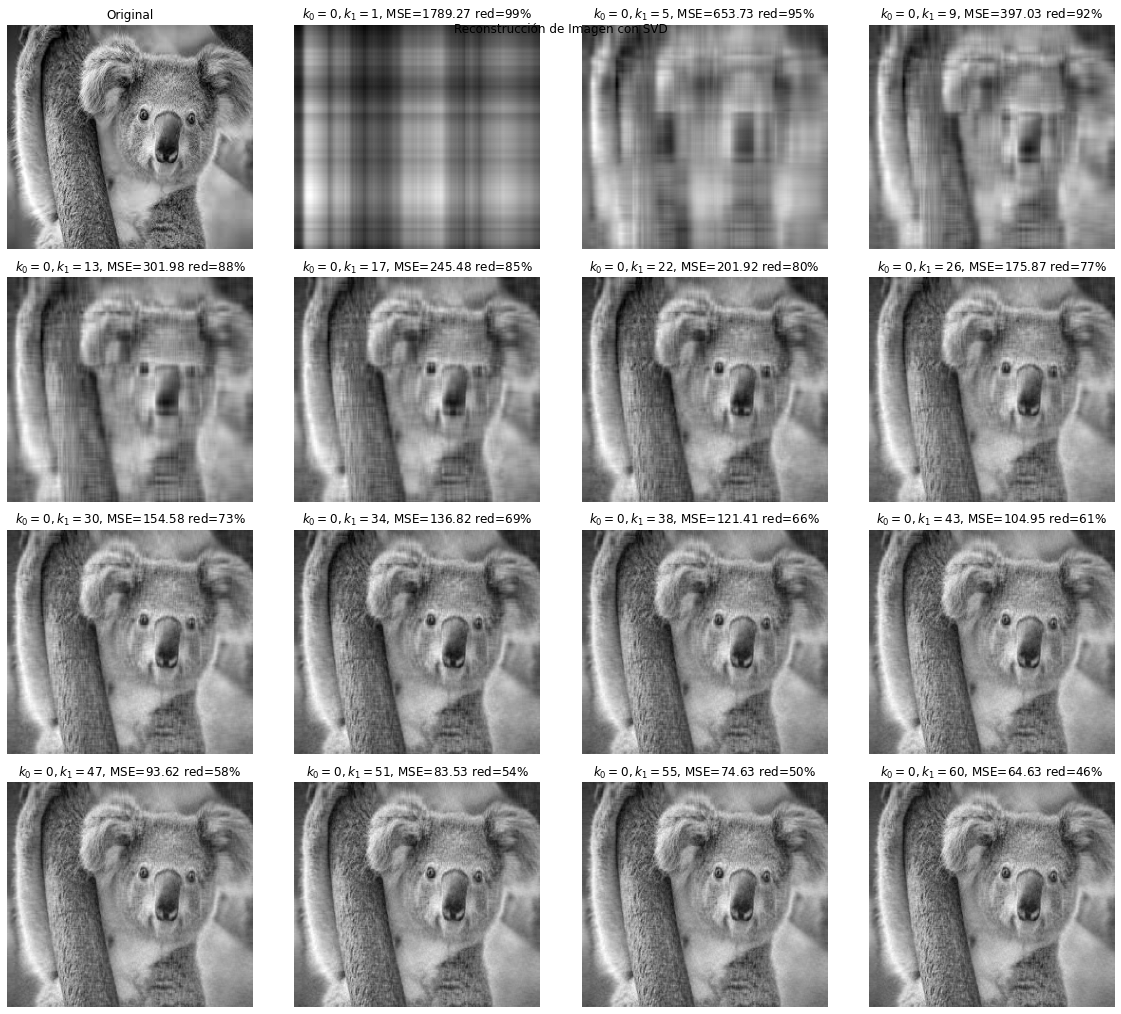

In [15]:
metrics_fixed_k0_moving_k1 = perform_svd_analysis(filename=TEST_IMAGE_FILENAME, 
        nk = 16, initial_k = 1, end_k = 60,fixed_k_idx=0, fixed_k_value=0, nx = 4)

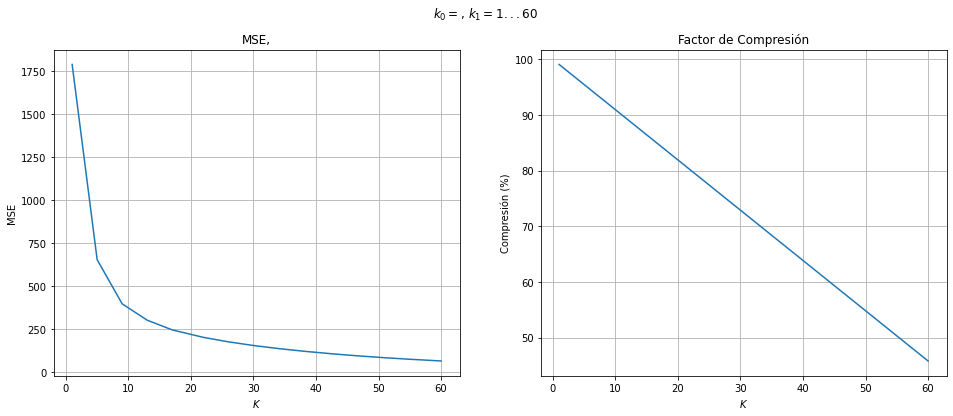

In [16]:
def plot_metrics(metrics, title):
    fig, ax = plt.subplots(1,2,figsize=(16,6))
    fig.suptitle(title)
    ax[0].plot(metrics[:,0],metrics[:,1]) 
    ax[0].set_ylabel("MSE")
    ax[0].set_title("MSE,")
    ax[1].plot(metrics[:,0],metrics[:,2])
    ax[1].set_ylabel("Compresión (%)")
    ax[1].set_title("Factor de Compresión")
    for i in range(2):
        ax[i].grid(which="Both")
        ax[i].set_xlabel("$K$")
        
plot_metrics(metrics_fixed_k0_moving_k1, "$k_0=$, $k_1=1...60$")       

Como se puede observar, a medida que aumenta $k_1$ disminuye el error y es menor el grado de compresión. Es interesante observar que para este ejemplo el error se reduce de manera drástica en los primeros 30 valores ensayados, mostrando una curva con un "codo" o "rodilla".

##### $k_1$ fijo, incremento gradual de $k_0$

Ahora se realizará al revés que en el caso anterior, manteniendo $k_1$ en 60 e incrementando en 15 pasos $k_0$ de 0 hasta 50.

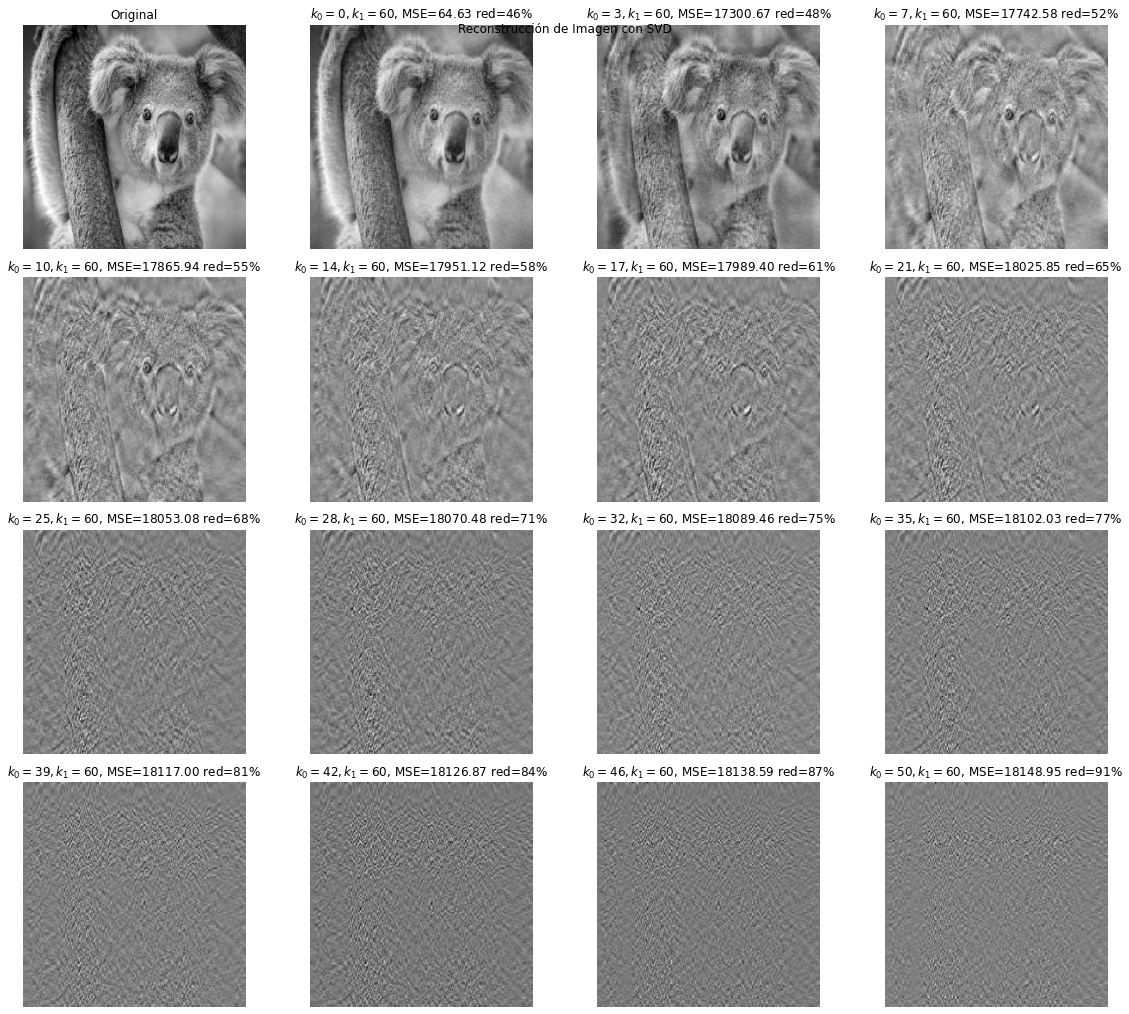

In [17]:
metrics_moving_k0_fixed_k1 = perform_svd_analysis(filename=TEST_IMAGE_FILENAME, 
        nk = 16, initial_k = 0, end_k = 50,fixed_k_idx=1, fixed_k_value=60, nx = 4)

A medida que se dejan de incluir los valores iniciales se vé cómo se va perdiendo la similitud con la señal original, quedando los componentes que agregan detalles de menor visibilidad.

### 2.3 Valor óptimo de truncado

Se volverá ahora al problema de encontrar un valor de truncado que ponga un limite al grado de detalle.
Una forma de calcular este número $k$ es encontrando un punto en el que la energía acumulada tenga un valor determinado siendo 0 la ausencia de señal y 1.0 el de máximo detalle, y por lo tanto, menor grado de compresión.

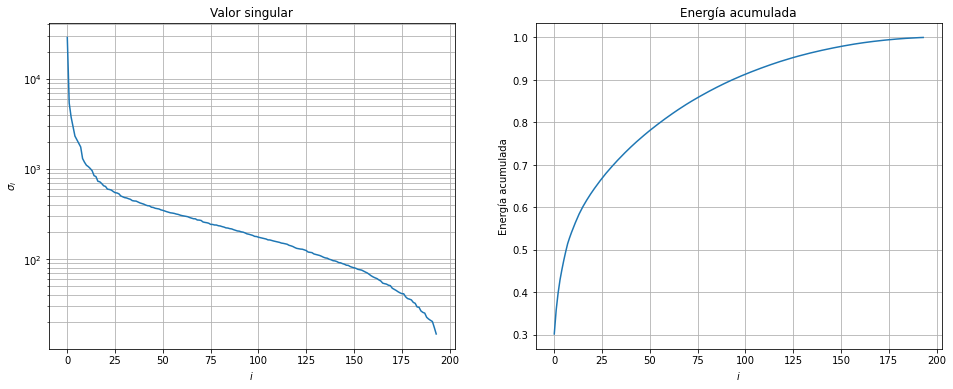

In [18]:
U, s, VT=np.linalg.svd(A) 
plot_sigma(s)

In [19]:
def find_k(s, threeshold):
    return np.max(np.where(np.cumsum(s)/np.sum(s) < threeshold))

70% de detalle.

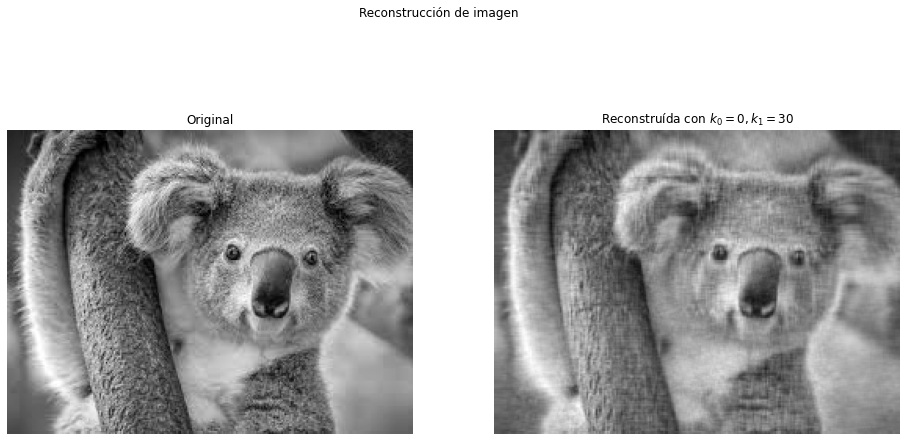

MSE: 154.58 
Factor de compresión: 72.89%


In [20]:
k = find_k(s,0.7)
Ared, s = plot_reconstructed(A,k)
mse = ((A-Ared)**2).mean()
print("MSE: %.2f " % mse )
print("Factor de compresión: %.02f%%" % reduction_factor(A.shape[0], A.shape[1],k) )

100% de detalle.

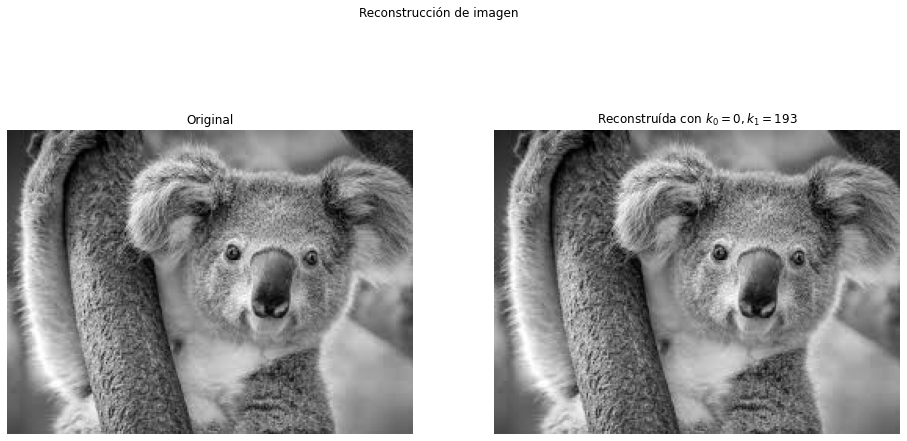

MSE: 0.00 
Factor de compresión: -74.39%


In [21]:
k = find_k(s,1.0)
Ared, s = plot_reconstructed(A,k)
mse = ((A-Ared)**2).mean()
print("MSE: %.2f " % mse )
print("Factor de compresión: %.02f%%" % reduction_factor(A.shape[0], A.shape[1],k) )

En este caso no hay error, pero tampoco hay compresión. De hecho, se necesitan más elementos para representar las matrices de factorización que la matriz original.

## Bibliografía y recursos consultados

- *Mathematics for Machine Learning*. M. Deisenroth, A. Faisal, and C. Ong. Cambridge University Press, (2020)
- [SVD Optimal Truncation]( https://www.youtube.com/watch?v=epoHE2rex0g). Accedido: 25/08/2020.
- [Gavish and Donoho "The Optimal Hard Threshold for Singular Values is $4/\sqrt{3}$](https://arxiv.org/abs/1305.5870) Accedido: 25/08/2020.
- [*SVD Based Image Processing Applications: State of The Art, Contributions and Research Challenges*. Rowayda A. Sadek](https://arxiv.org/pdf/1211.7102.pdf). Accedido 25/08/2020
- [*Singular Value Decomposition Applied To Digital Image Processing*. Lijie Cao](https://www.math.cuhk.edu.hk/~lmlui/CaoSVDintro.pdf). Accedido: 25/08/2020.